In [2]:
%load_ext Cython

In [6]:
%%cython
# distutils: language = c++
from cython.parallel import prange
from libc.stdlib cimport rand, RAND_MAX
from libc.math cimport abs, round, cos, sin
from scipy.special.cython_special import radian
from libcpp.vector cimport vector
from libc.string cimport memcpy, strcmp
from libcpp.string cimport string

from cython cimport boundscheck, wraparound
from numpy cimport ndarray, uint8_t, float64_t
from numpy import copy, asarray, ascontiguousarray, uint8, float64, zeros,rot90, flip, random, sum, linspace, min, max
ctypedef unsigned char uchar
cdef class ImgAugmentation:
    cdef:
        vector[vector[vector[uchar*]]] images
        uchar[:,:] image
    def __cinit__(self, double[:,:,:,:,:] images, int rotation_range, int horizontal_flip, int vertical_flip,
                                int shear_range, int noise_range):
        #print("shape: ",self.images.shape)
        if(images.size!=0):
            print(images.shape)
            self.select_algorithm(images, rotation_range, horizontal_flip, vertical_flip, shear_range, noise_range)

   
    @boundscheck(False)  # Deactivate bounds checking
    @wraparound(False)
    cdef int random_number(self)nogil:
        cdef int num = (rand() % 7 +1) #1 + rand()/(RAND_MAX*6.0)
        return num

    @boundscheck(False)  # Deactivate bounds checking
    @wraparound(False)
    cdef void select_algorithm(self, double[:,:,:,:,:]images, int rotation_range, int horizontal_flip, int vertical_flip,
                                int shear_range, int noise_range)nogil:
        cdef:
            unsigned int i,j,k
            uchar[:,:] image
            unsigned int rand_num
            vector[vector[uchar*]] img
            vector[uchar*] im
            
        for i in range(images.shape[0]):
            img.clear()
            rand_num = <int>self.random_number()
            for j in range(images.shape[1]):
                im.clear()
                for k in range(images.shape[2]):
                    with gil:
                        image = asarray(images[i,j,k], dtype=uint8)
                        self.image = self._select_algorithm(image, rand_num, rotation_range, horizontal_flip,
                                                        vertical_flip, shear_range, noise_range)
                        #print("index 10->", j, "index 7->", k, "shape->",self.image.shape)
                        im.push_back(self.converter(self.image))
                        #print("vector 1->",im.size())
                    img.push_back(im)         
                    #print("vector 2->",img.size())
                self.images.push_back(img)
                #print("vector 3->",self.images.size())

    @boundscheck(False)  # Deactivate bounds checking
    @wraparound(False)                
    cdef uchar* converter(self, uchar[:,:] array ):
        cdef ndarray[uint8_t, ndim=2, mode ='c'] np_buff = ascontiguousarray(array, dtype=uint8)
        cdef uchar *im_buff = <uchar*>np_buff.data
        return im_buff
   
    @boundscheck(False)  # Deactivate bounds checking
    @wraparound(False)                
    cdef uchar[:,:] _select_algorithm(self, uchar[:,:]img, int rand_num, int rotation_range, 
                                int horizontal_flip, int vertical_flip, int shear_range, int noise_range):
        #print("rand number", rand_num)
        if (rand_num == 1):
            return self._rotation(img, 0, rotation_range)
        elif (rand_num == 2):
            return self._flipping(img, horizontal_flip)
        elif (rand_num == 3):
            return self._shearing(img, shear_range)
        elif (rand_num == 4):
            return self._flipup(img, vertical_flip)
        elif (rand_num == 5):
            return self._cropping(img)
        elif (rand_num == 6):
            return self._add_noise(img, noise_range, b"gauss")
        elif (rand_num == 7):
            return self._brightness(img)
    @boundscheck(False)  # Deactivate bounds checking
    @wraparound(False)
    cdef uchar[:,:] _rotation(self, uchar[:,:] image, int e_1, int e_2):
        return rot90(image, k=1, axes=(e_1, e_2))
    @boundscheck(False)  # Deactivate bounds checking
    @wraparound(False)
    cdef uchar[:,:]  _flipping(self, uchar[:,:] image, int p):
        return asarray(flip(image, p), dtype=uint8)
    @boundscheck(False)  # Deactivate bounds checking
    @wraparound(False)
    cdef uchar[:,:] _shearing(self, uchar[:,:] image, float angle):
        cdef :
            float cosine, sine, x, y
            unsigned int height, width, new_x, new_y, new_height, new_width
            float original_centre_height, original_centre_width, new_centre_heigh, new_centre_width   
            uchar[:,:] output 
            unsigned int i, j
            
        # Define the most occuring variables
        angle=radian(angle,0,0)                               #converting degrees to radians
        cosine=cos(angle)
        sine=sin(angle)
        height=image.shape[0]                                   #define the height of the image
        width=image.shape[1]                                    #define the width of the image
        
        # Define the height and width of the new image that is to be formed
        new_height  = <unsigned int>round(abs(image.shape[0]*cosine)+abs(image.shape[1]*sine))+1
        new_width  =<unsigned int> round(abs(image.shape[1]*cosine)+abs(image.shape[0]*sine))+1

            # define another image variable of dimensions of new_height and new _column filled with zeros
        output=zeros((new_height,new_width), dtype=uint8)

        # Find the centre of the image about which we have to rotate the image
        original_centre_height = round(((image.shape[0]+1)/2)-1)    #with respect to the original image
        original_centre_width  = round(((image.shape[1]+1)/2)-1)    #with respect to the original image

        # Find the centre of the new image that will be obtained
        new_centre_height= round(((new_height+1)/2)-1)        #with respect to the new image
        new_centre_width= round(((new_width+1)/2)-1)          #with respect to the new image

        for i in range(height):
            for j in range(width):
                #co-ordinates of pixel with respect to the centre of original image
                y=<float>image.shape[0]-1-i-original_centre_height                   
                x=<float>image.shape[1]-1-j-original_centre_width                      

                #co-ordinate of pixel with respect to the rotated image
                y=<float>round(-x*sine+y*cosine)
                x=<float>round(x*cosine+y*sine)

                '''since image will be rotated the centre will change too, 
                   so to adust to that we will need to change new_x and new_y with respect to the new centre'''
                new_y=<int>new_centre_height-<int>y
                new_x=<int>new_centre_width-<int>x

                # adding if check to prevent any errors in the processing
                if (0 <= new_x < new_width) and (0 <= new_y < new_height) and (new_x>=0) and (new_y>=0):
                    output[new_y,new_x]=image[i,j]
        return asarray(output, dtype=uint8)
    
    @boundscheck(False)  # Deactivate bounds checking
    @wraparound(False)
    cdef uchar[:,:]  _flipup(self, uchar[:,:] image, int p ):
        return asarray(flip(image, p), dtype=uint8)
    @boundscheck(False)  # Deactivate bounds checking
    @wraparound(False)
    cdef uchar[:,:] _cropping(self, uchar[:,:] image):
        return asarray(image, dtype=uint8)
    @boundscheck(False)  # Deactivate bounds checking
    @wraparound(False)
    cdef uchar[:,:] _brightness(self, uchar[:,:] image ):
        cdef: 
            int ma, mi
            uchar[:] LUT
            
        mi=<int>min(image)        # result=144
        ma=<int>max(image)        # result=216
        # Make a LUT (Look-Up Table) to translate image values
        LUT=zeros(256,dtype=uint8)
        LUT[mi:ma+1]=linspace(start=0,stop=255,num=(ma-mi)+1,endpoint=True,dtype=uint8)
        return LUT.base[image]
    @boundscheck(False)  # Deactivate bounds checking
    @wraparound(False)
    cdef uchar[:,:]  _add_noise(self, uchar[:,:] image, float var, string noise_typ ):
        cdef:
            int row, col,
            float sigma, mean
            uchar[:,:] gauss, noisy
        if noise_typ == b"gauss":
            row = image.shape[0]
            col = image.shape[1]
            mean = 0.0
            sigma = var**0.5
            gauss = asarray(random.normal(mean,sigma,(row,col)),dtype=uint8).reshape(row,col)
            #gaus= gauss.reshape(row,col)
            noisy = asarray(image, dtype=uint8) + asarray(gauss, dtype=uint8)
            return asarray(noisy,dtype=uint8)
                             
            
    def get_image(self):
        return self.images
    def get_rand_num(self):
        return int(self.random_number())


In file included from /usr/local/lib/python3.8/dist-packages/numpy/core/include/numpy/ndarraytypes.h:1969,
                 from /usr/local/lib/python3.8/dist-packages/numpy/core/include/numpy/ndarrayobject.h:12,
                 from /usr/local/lib/python3.8/dist-packages/numpy/core/include/numpy/arrayobject.h:4,
                 from /home/cristian/.cache/ipython/cython/_cython_magic_aa23b0df3f31f7cebef93365362b222f.cpp:660:
/usr/local/lib/python3.8/dist-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: #warning "Using deprecated NumPy API, disable it with " "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-Wcpp]
   17 | #warning "Using deprecated NumPy API, disable it with " \
      |  ^~~~~~~


In [7]:
from numpy import zeros, uint8, float64
z = zeros((1000,10,7,120,160), dtype=float64)

In [8]:
path =b"./spatial_transformer.png"
image = z[:]
rotation_range= 1
horizontal_flip=0
vertical_flip = 1
shear_range = 20.0
noise_range = 9 
img = ImgAugmentation(image, rotation_range, horizontal_flip, vertical_flip, shear_range, noise_range )
#img.get_image().shape
#img.get_rand_num()

[1000, 10, 7, 120, 160, 0, 0, 0]


float64


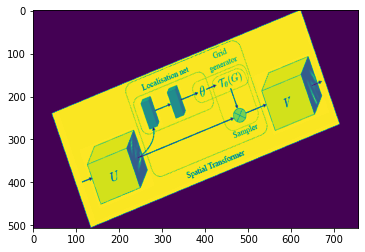

In [65]:
from matplotlib.pyplot import imshow, show
from numpy import flip, asarray, float64, kron, zeros, ones, random, uint8, rot90
from PIL import Image
img = Image.open(path)
img = asarray(img, dtype=uint8)
im1 = imshow(img)
img = img[:,:,0]
#print(img.shape)
#img = flip(img, 0)
#img = crop_center(img, 120,160)
#kron(img, ones((6,6)))
#img = noisy("gauss", img)
#img = brightness(img)
#img = rot90(img, k=1, axes=(0,1))
img = shear(20.0, img)
print(img.dtype)
im2 = imshow(img)
show()